In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)



In [5]:
import pandas as pd
from pathlib import Path

path = Path("C:\\Users\\zenith\\PycharmProjects\\MachineLearning\\mydatasets\\Ridership.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

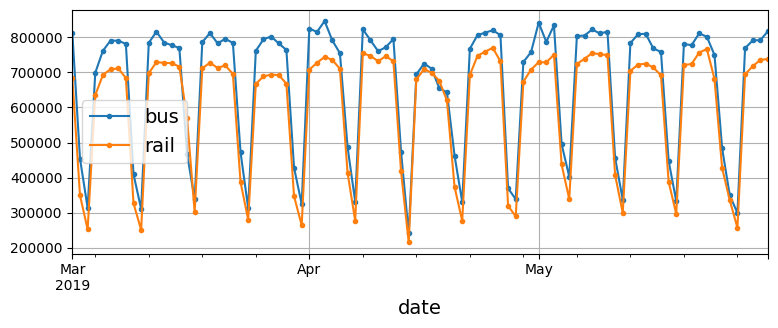

In [6]:
df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

In [7]:
# Organize data

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [8]:
# Define a simple RNN with just one recurrent neuron to perform predictions

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [9]:
# Evaluate the model and fit it based on a training and test set

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [10]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 5s 28ms/step - loss: 0.0217 - mae: 0.1632 - val_loss: 0.0199 - val_mae: 0.1387
Epoch 2/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0171 - mae: 0.1549 - val_loss: 0.0179 - val_mae: 0.1493
Epoch 3/500
33/33 [==============================] - 1s 18ms/step - loss: 0.0167 - mae: 0.1541 - val_loss: 0.0176 - val_mae: 0.1615
Epoch 4/500
33/33 [==============================] - 1s 20ms/step - loss: 0.0165 - mae: 0.1552 - val_loss: 0.0173 - val_mae: 0.1545
Epoch 5/500
33/33 [==============================] - 1s 27ms/step - loss: 0.0163 - mae: 0.1577 - val_loss: 0.0171 - val_mae: 0.1522
Epoch 6/500
33/33 [==============================] - 1s 19ms/step - loss: 0.0162 - mae: 0.1570 - val_loss: 0.0174 - val_mae: 0.1421
Epoch 7/500
33/33 [==============================] - 1s 17ms/step - loss: 0.0161 - mae: 0.1554 - val_loss: 0.0170 - val_mae: 0.1461
Epoch 8/500
33/33 [==============================] - 1s 18ms/step - loss: 0.

102808.43079090118